# Observations in PHX Using A Radio Horn

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import chart
from scipy import signal
from scipy.ndimage import median_filter
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import chart
from astropy import units as u
from astropy.coordinates import SpectralCoord, EarthLocation, SkyCoord
from astropy.time import Time
import pandas as pd
import scipy.stats as stays
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math

f0 = 1.420405751768  # GHz
speed_of_light = 299792458  # m/s
def plot_f0(lims=[20, 50], xval=f0):
    plt.plot([xval, xval], lims, '--k', lw=0.5)
def f2v(freq):
        return -(np.array(freq)-f0) * speed_of_light / np.array(freq)

# Where is the data located?

In [2]:
data_dir = '/home/lmberkhout/CHARTDATA/'
paths = ['PHX_BABY1_11_11_2022',
        'PHX_BABY2_11_11_2022']

# Make a simple plot of the two data trials.

2


Text(0.5,0,'Frequency [GHz]')

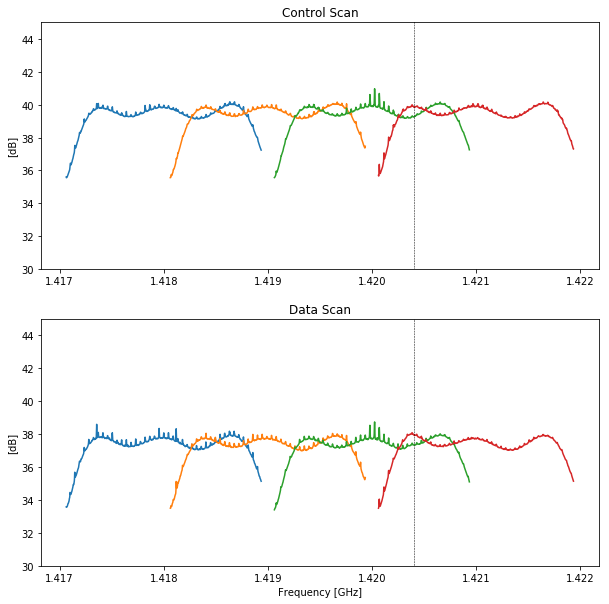

In [3]:
ntrials = len(paths)
print(ntrials)
data = []
mdata = []
spectra = [[] for _ in range(ntrials)]
freqs = [[] for _ in range(ntrials)]

for i in range(ntrials):
    d, m = chart.analysis.read_run(directory=data_dir + paths[i])
    d = np.array(d)
    data.append(d)
    mdata.append(m)
    nchans = m[0]['vector_length']
    nremove = nchans // 32
    

for j in range(ntrials):
    for d, m in zip(data[j], mdata[j]):
        spectrum = np.mean(d, axis=0) 
        spectrum = spectrum[nremove:-nremove]
        spectrum = 10 * np.log10(spectrum)
        frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                           * m['samp_rate'] / m['vector_length'] + m['frequency'])
        frequencies = 1e-9 * frequencies[nremove:-nremove]
        spectra[j].append(spectrum)
        freqs[j].append(frequencies)

    for k in range(len(spectra[j]) - 1):
        spec1 = spectra[j][k]
        spec2 = spectra[j][k + 1]
        freq1 = freqs[j][k]
        freq2 = freqs[j][k + 1]
        ncommon = np.sum([1 if f in freq2 else 0 for f in freq1])
        spec2 += np.median(spec1[-ncommon:]) - np.median(spec2[:ncommon])
        spectra[j][k + 1] = spec2
    
plt.figure(figsize=(10,10))

for j in range(ntrials):
    if j == 0:
        ax = plt.subplot(ntrials, 1, j + 1)
        ax.set_title('Control Scan')
    else:
        plt.subplot(ntrials, 1, j + 1, sharex=ax, sharey=ax)
        plt.title('Data Scan')
    for f, s in zip(freqs[j], spectra[j]):
        plt.plot(f, s)
    plt.ylabel('[dB]')
    plot_f0()
    
plt.ylim(30,45)
plt.xlabel('Frequency [GHz]')

# Bandpass Calibration

In [4]:
ntrials = len(paths)
data = []
mdata = []
bps= []
spectra = [[] for _ in range(ntrials)]
freqs = [[] for _ in range(ntrials)]

for i in range(ntrials):
    d, m = chart.analysis.read_run(directory=data_dir + paths[i])
    d = np.array(d)
    data.append(d)
    mdata.append(m)
    nchans = m[0]['vector_length']
    nremove = nchans // 32
for i in range(ntrials):
    d, m = chart.analysis.read_run(directory=data_dir + paths[i])
    d = np.array(d)
    data.append(d)
    mdata.append(m)
    # Rough estimate for bandpass
    nchans = m[0]['vector_length']
    levels = np.median(d[:, :, nchans // 4:(-nchans // 4)], axis=(1, 2))
    rescaled = d / levels.reshape(-1, 1, 1)
    bp = np.median(rescaled, axis=(0, 1))
    bps.append(bp)
    
for j in range(ntrials):
    for d, m in zip(data[j], mdata[j]):
        spectrum = np.mean(d, axis=0) / bps[j]
        spectrum = spectrum[nremove:-nremove]
        spectrum = 10 * np.log10(spectrum)
        frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                           * m['samp_rate'] / m['vector_length'] + m['frequency'])
        frequencies = 1e-9 * frequencies[nremove:-nremove]
        spectra[j].append(spectrum)
        freqs[j].append(frequencies)

    for k in range(len(spectra[j]) - 1):
        spec1 = spectra[j][k]
        spec2 = spectra[j][k + 1]
        freq1 = freqs[j][k]
        freq2 = freqs[j][k + 1]
        ncommon = np.sum([1 if f in freq2 else 0 for f in freq1])
        spec2 += np.median(spec1[-ncommon:]) - np.median(spec2[:ncommon])
        spectra[j][k + 1] = spec2

A quick look at each trial individually. Color corresponds to different tunings.

No handles with labels found to put in legend.


Text(0.5,0,'Frequency [GHz]')

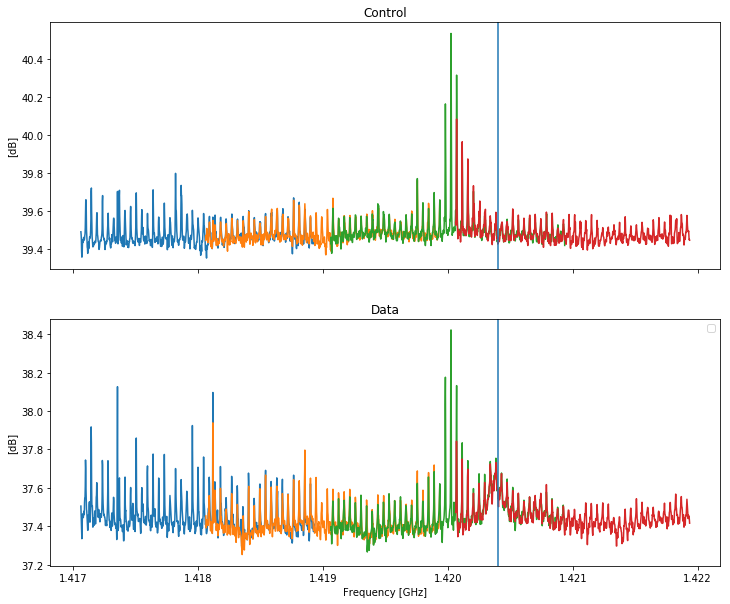

In [5]:
fig,axs = plt.subplots(ntrials, 1, sharex=True, figsize=(12,10))
for j in range(ntrials):
    for f, s in zip(freqs[j], spectra[j]):
        axs[j].plot(f, s)
    if j==0:
        axs[j].set_title('Control')
    if j==1:
        axs[j].set_title('Data')
    axs[j].set_ylabel('[dB]')
    axs[j].axvline(1.4204)
    #plot_f0(lims=[37, 39])
    
plt.legend()
plt.xlabel('Frequency [GHz]')

In [6]:
smoothed = []
zscores = []
mask = []
kern = 25
footprint = np.ones(2 * kern + 1)
footprint[kern] = 0

for data in spectra[1]:
    
    data = np.concatenate([data[kern - 1::-1], data, data[:-kern - 1:-1]])
    d_sm = median_filter(data.real, footprint=footprint)
    d_rs = data - d_sm
    d_sq = np.abs(d_rs)**2
    # Factor of .456 is to put mod-z scores on same scale as standard deviation.
    sig = np.sqrt(median_filter(d_sq, footprint=footprint) / .456)
    zscore = (d_rs / sig)[kern:-kern]
    smoothed.append(d_sm[kern:-kern])
    zscores.append(zscore)
    mask.append(zscore > 1.5)


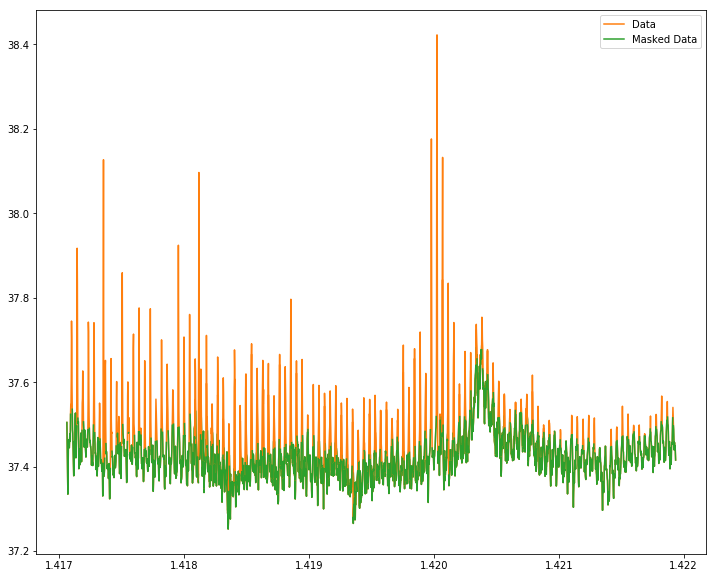

In [7]:
plt.figure(figsize=(12,10))

for i, spec in enumerate(spectra[1]):
    if i == 0:
        plt.plot(freqs[1][i], spec, color='C1', label='Data')
        plt.plot(freqs[1][i], np.ma.masked_array(spec, mask[i]), color='C2', label='Masked Data')
    else:
        plt.plot(freqs[1][i], spec, color='C1')
        plt.plot(freqs[1][i], np.ma.masked_array(spec, mask[i]), color='C2')
    plt.legend()

# Masked Spectrum

(1.419, 1.422)

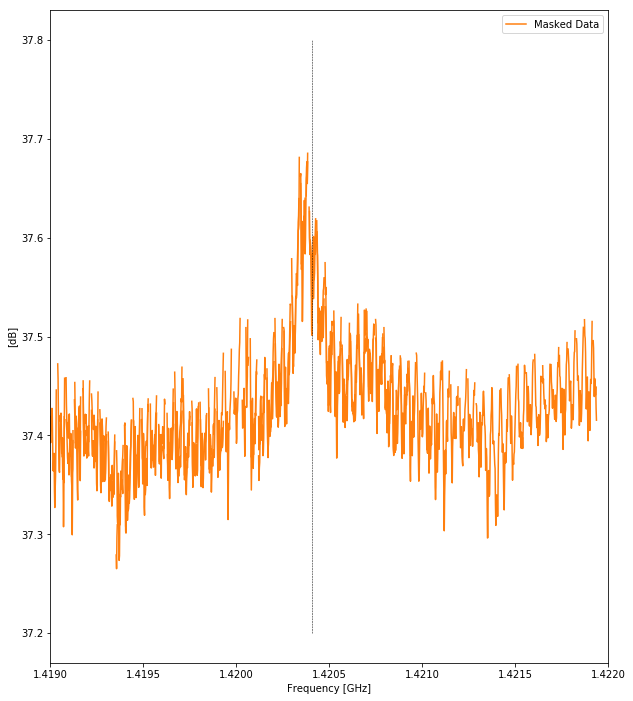

In [8]:
plt.figure(figsize=(10,12))
j = 1
for k in range(len(freqs[j])):
    data = np.ma.masked_array(spectra[j][k], mask[k])
    if k == 0:
        plt.plot(freqs[j][k], data, 'C' + str(j), label='Masked Data')
    else:
        plt.plot(freqs[j][k], data, 'C' + str(j))
plt.ylabel('[dB]')
plot_f0(lims=(37.2,37.8))
plt.legend()
plt.xlabel('Frequency [GHz]')
plt.xlim([1.419, 1.422])

# Average overlapping scans 

In [9]:
# Do a very brute-force infill

j = 1
for k in range(len(freqs[j])):
    for ind in np.where(mask[k])[0]:
        # find nearest below
        if ind > 0 and ind < (len(spectra[j][k])-1):
            left = np.where(np.where(~mask[k])[0] < ind)[0]
            if len(left) > 0:
                ind1 = np.max(left)
            else:
                ind1 = 0
            ind1 = np.where(~mask[k])[0][ind1]
            right = np.where(np.where(~mask[k])[0] > ind)[0]
            if len(right) > 0:
                ind2 = np.min(right)
            else:
                ind2 = len(np.where(~mask[k][0]))
            ind2 = np.where(~mask[k])[0][ind2]

            # point slope
            slope = (spectra[j][k][ind2] - spectra[j][k][ind1]) / (ind2 - ind1)
            spectra[j][k][ind] = slope * (ind - ind1) + spectra[j][k][ind1]
    spectra[j][k] = median_filter(spectra[j][k], 5)

In [10]:
allfreqs = np.unique(freqs)
allspec = np.zeros(len(allfreqs))
counts = np.zeros(len(allfreqs))
for k in range(len(freqs[j])):
    for chan in range(len(freqs[j][k])):
        ind = np.where(freqs[j][k][chan] == allfreqs)[0]
        allspec[ind] += spectra[j][k][chan]
        counts[ind] += 1
allspec = allspec / counts

(1.419, 1.422)

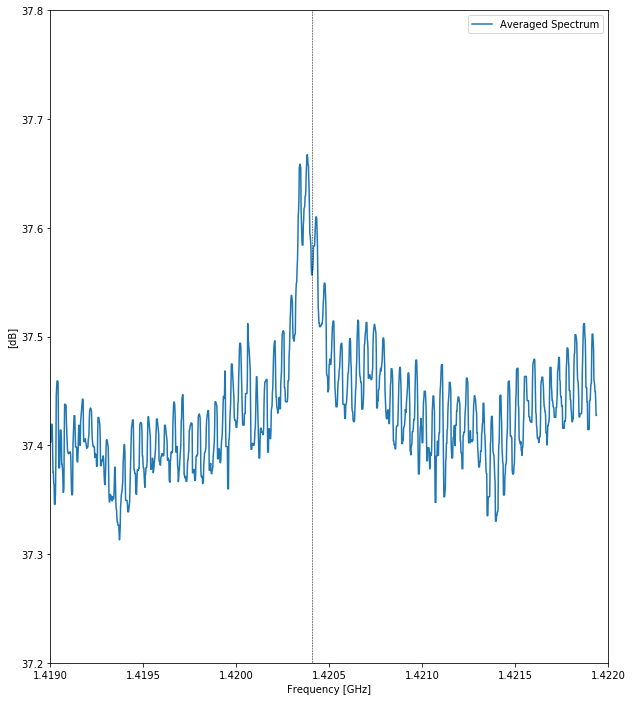

In [11]:
# Have a look at my unified spectrum
plt.figure(figsize=(10,12))
plt.plot(allfreqs, allspec, label='Averaged Spectrum')
plt.ylabel('[dB]')
plot_f0()
plt.legend()
plt.xlabel('Frequency [GHz]')
plt.ylim([37.2, 37.8])
plt.xlim([1.419, 1.422])

(1.4205, 1.421)

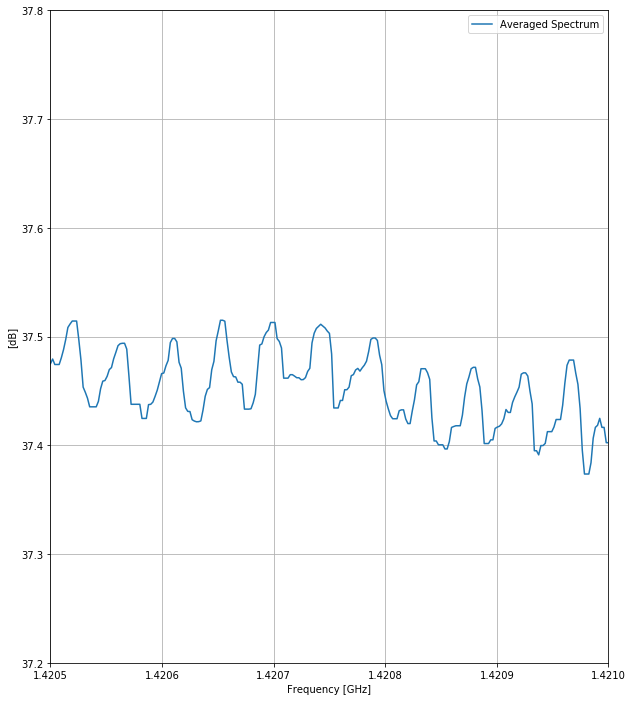

In [12]:
plt.figure(figsize=(10,12))
plt.plot(allfreqs, allspec, label='Averaged Spectrum')
plt.ylabel('[dB]')
plot_f0()
plt.legend()
plt.xlabel('Frequency [GHz]')
plt.ylim([37.2, 37.8])
plt.grid()
plt.xlim([1.4205, 1.4210])

## Delay filter

Before we do that, let's get a rough estimate of where we expect the offending peak will be. Doing some poking on the plot above, I counted ten peaks between 1.4195306 and 1.4199818 GHz. So I'd expect the peak to be approximately $\tau=10/(1.4199818 - 1.4195306) \text{ ns} = 22,163 \text{ ns}$.

Let's take a look.

Text(0.5,0,'Delay (ns)')

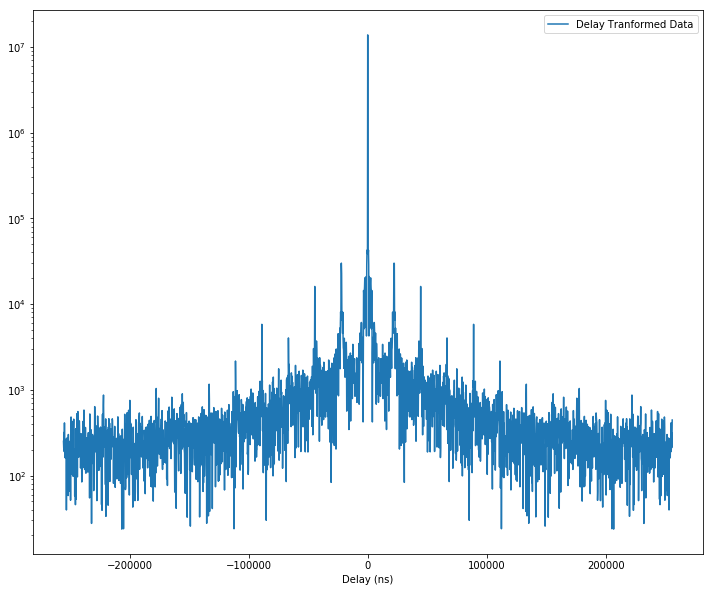

In [13]:
ft = np.fft.fftshift(np.fft.fft(10**(allspec/10),len(allfreqs)))
fftfreq = np.fft.fftshift(np.fft.fftfreq(len(allspec), allfreqs[1]-allfreqs[2]))
plt.figure(figsize=(12,10))
plt.semilogy(fftfreq, np.abs(ft), label='Delay Tranformed Data')
plt.legend()
plt.xlabel('Delay (ns)')

That first peak is just about 22,200 ns. Science baby!

Let's filter it and some of its buddies out. 

(0, 25000.0)

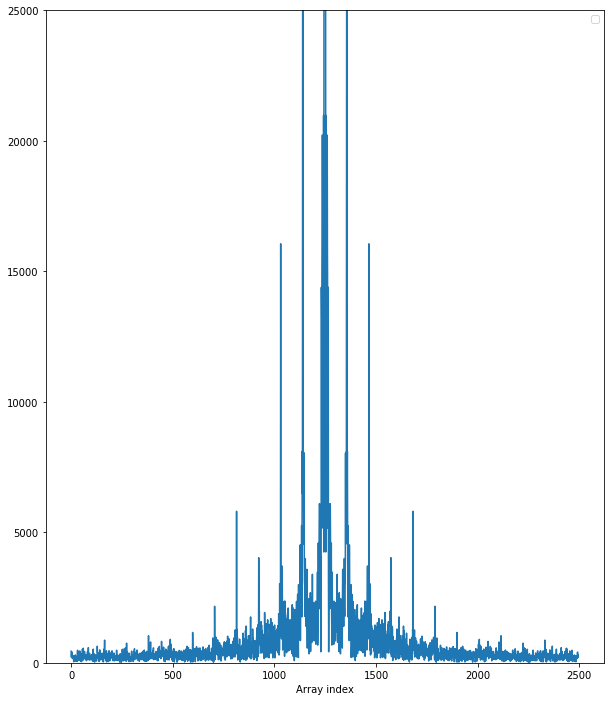

In [14]:
# Plot with index numbers so I can grab them by hand for filtering.
plt.figure(figsize=(10,12))
plt.plot(np.abs(ft))
plt.xlabel('Array index')
plt.legend('')
plt.ylim([0, 25e3])

In [15]:
spike_inds = np.array([814, 921, 922, 923, 1031, 1139, 1140, 1141, 1355, 1356, 1357, 1465, 1573, 1574, 1575, 1682])
nmiddle = 2
middle_inds = np.arange(1248 - nmiddle, 1248 + nmiddle + 1)

# let's try infilling again
mask = np.zeros(len(ft), dtype=bool)
mask[spike_inds] = True
for ind in spike_inds:
    left = np.where(np.where(~mask)[0] < ind)[0]
    ind1 = np.max(left)
    ind1 = np.where(~mask)[0][ind1]
    right = np.where(np.where(~mask)[0] > ind)[0]
    ind2 = np.min(right)
    ind2 = np.where(~mask)[0][ind2]
    
    slope = (ft[ind2] - ft[ind1]) / (ind2 - ind1)
    ft[ind] = slope * (ind - ind1) + ft[ind1]

offset = ft[1248]
ft[middle_inds] = 0
ft[1248] = offset

(0, 25000.0)

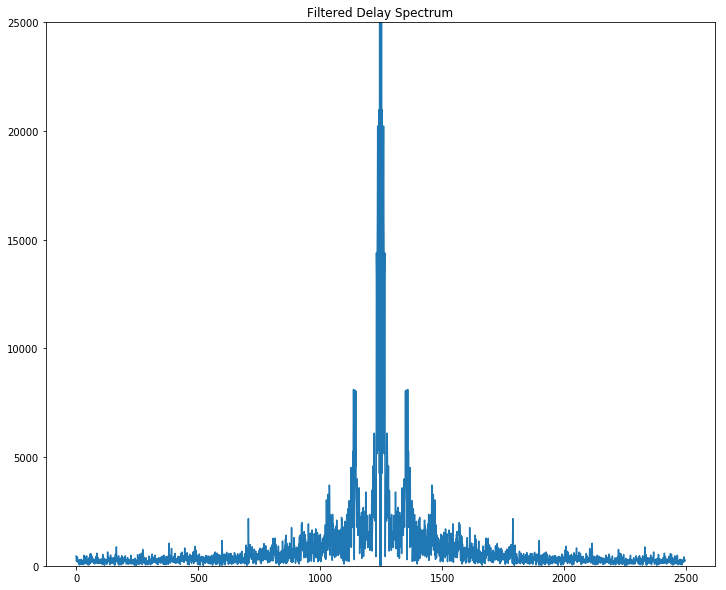

In [16]:
plt.figure(figsize=(12,10))
plt.title('Filtered Delay Spectrum')
plt.plot(np.abs(ft))
plt.ylim([0, 25e3])

In [17]:
dfiltered = np.abs(np.fft.ifft(np.fft.ifftshift(ft)))
dfiltered = 10 * np.log10(dfiltered)

(1.419, 1.422)

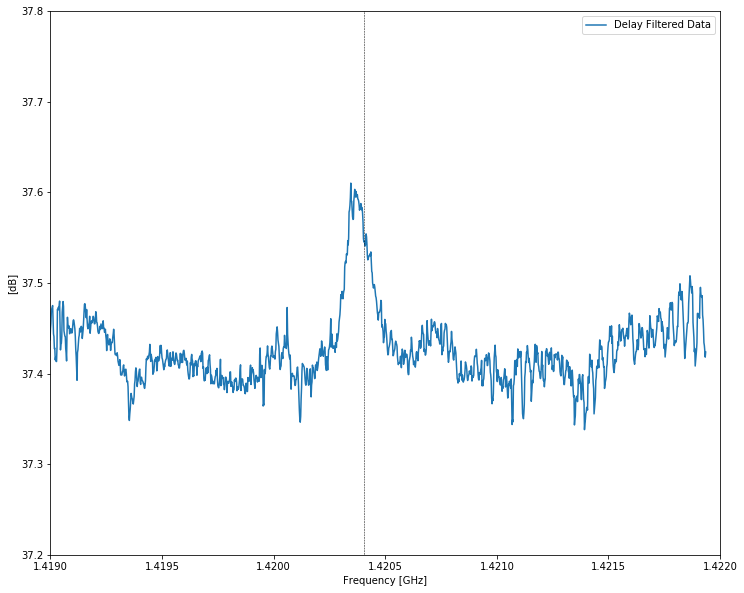

In [18]:
plt.figure(figsize=(12,10))
plt.plot(allfreqs, dfiltered,label='Delay Filtered Data')
plt.ylabel('[dB]')
plot_f0()
plt.legend()
plt.xlabel('Frequency [GHz]')
plt.ylim([37.2, 37.8])
plt.xlim([1.419, 1.422])

# Convert to velocity

Text(0.5,0,'Velocity (km/s)')

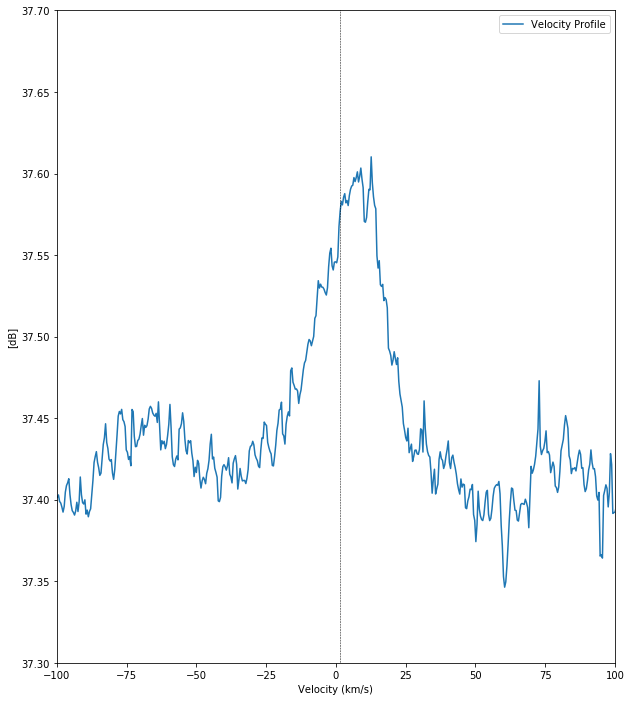

In [19]:
plt.figure(figsize=(10,12))
velocity = f2v(allfreqs) / 1000
plt.ylim([37.3, 37.7])
plt.xlim(-100,100)
plt.plot(velocity, dfiltered, label = 'Velocity Profile')
plt.ylabel('[dB]')
plot_f0()
plt.legend()
plt.xlabel('Velocity (km/s)')
